In [ ]:
# from PyQt5.QtCore import QT_VERSION_STR

In [3]:
%matplotlib inline
# %matplotlib qt 
import matplotlib
matplotlib.use('Qt5Agg')

# Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()


In [4]:
# import mpld3
# from mpld3 import plugins
# plugins.connect(image, plugins.MousePosition(fontsize=14))
# mpld3.enable_notebook()

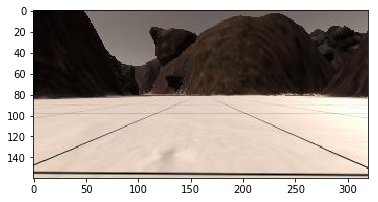

In [8]:
path = '../collected_images/IMG/robocam_2017_12_06_05_49_10_984.jpg'
image = mpimg.imread(path)
plt.imshow(image)

Below seems to produce a slightly rotated transformation look at later if need be

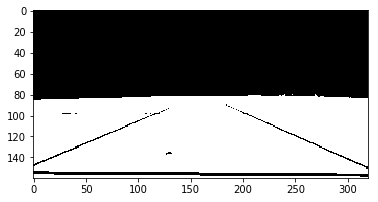

In [9]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(image)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

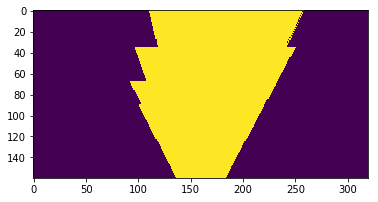

In [11]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side

map_grid_side = 10
dst_size = map_grid_side / 2 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 2
source = np.float32([[118, 99], [203, 99], [182, 90], [136, 90]])
destination = np.float32([
    [image.shape[1]/2 - dst_size, image.shape[0] + map_grid_side - bottom_offset],
    [image.shape[1]/2 + dst_size, image.shape[0] + map_grid_side - bottom_offset],
    [image.shape[1]/2 + dst_size, image.shape[0] - map_grid_side - 2*dst_size - bottom_offset], 
    [image.shape[1]/2 - dst_size, image.shape[0] - map_grid_side - 2*dst_size - bottom_offset],
])
warped = perspect_transform(threshed, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

In [ ]:
class MappingMap(np.ndarray):
    __init__():
        pass

In [ ]:
class ExpandingMap(object):
    def __init__(self, np_arr):
        self._array = np.array(np_arr)
        maybe_initialize_a_map_with_neg_1s_and_shit
    def __add__(self, other_np_array, addition_point):
        if addition_point + other_np_array_dims_y > self_arr_dims:
            create_a_new_larger_array_of_size
            set_array_to_be_so_and_so
        return np.add(self._array, other_np_array)
    def maybe_no_add_just_expand_map_by_matching